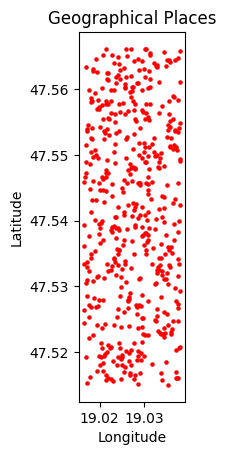

In [36]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the CSV file into a DataFrame
df = pd.read_csv('helyszinek.csv')

# Ensure the DataFrame has 'latitude' and 'longitude' columns
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Plot the GeoDataFrame
gdf.plot(marker='o', color='red', markersize=5)
plt.title('Geographical Places')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [6]:
import plotly.express as px

# Create a scatter mapbox plot
fig = px.scatter_mapbox(
    gdf,
    lat='latitude',
    lon='longitude',
    hover_name='contact',
    hover_data={'area': True, 'rent': True, 'competitors': True, 'exposure': True, 'population': True},
    color_discrete_sequence=['red'],
    zoom=12,
    height=600
)

# Update layout for the map
fig.update_layout(
    mapbox_style='open-street-map',
    title='Geographical Places'
)

# Show the plot
fig.show()

In [38]:
import math

current_customers = 120
average_spending_loyal = 12000
average_spending_new = 6000
distance_penalty_per_30m = 1  # lose one loyal customer for every 30 meters distance
loyal_customer_area = 15  # for 10 loyal customers
main_area = 400  # additional area needed for brewing equipment
lat = 47.541766
lon = 19.038464

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    R = 6371000 
    distance = R * c
    return math.ceil(distance)

# Function to calculate the profit from a location
def calculate_profit(row):
    # Calculate the maximum number of tables that can fit in the area
    max_tables = (row['area'] - main_area) // loyal_customer_area
    max_loyal_customers = min(max_tables * 10, current_customers)

    
    # Calculate the distance impact
    distance = haversine(lat, lon, row['latitude'], row['longitude'])
    lost_customers = distance // 30 * distance_penalty_per_30m
    effective_loyal_customers = max(0, max_loyal_customers - lost_customers)
    total_space_left = row['area'] - main_area - (effective_loyal_customers // 10 * loyal_customer_area)
    
    # Calculate new customers based on population and competitors
    new_customers = 0
    if row['competitors'] > 0:
        # Calculate market share for new customers
        potential_clients = row['population'] * row['exposure']
        potential_clients_per_competitor = potential_clients / row['competitors']
        potential_housable_clients = total_space_left // loyal_customer_area * 10

        # Calculate the number of new customers
        new_customers = min(potential_housable_clients, potential_clients_per_competitor)
        

    # Total profit
    profit = (effective_loyal_customers * average_spending_loyal) + (new_customers * average_spending_new)
    return profit

# Apply the profit calculation to each location
#df['profit'] = df.apply(calculate_profit, axis=1)

# Find the location with the highest profit
#best_location = df.loc[df['profit'].idxmax()]

#best_location_info = best_location[['contact', 'profit']]
#best_location_info




In [22]:
profit_takacsjozsef = df[df['contact'] == 'takacsjozsef@gmail.com']['profit'].values[0]

profit_takacsjozsef

2280000.0

In [23]:
second_best_location = df.nlargest(2, 'profit').iloc[1]
second_best_location

contact        tithagnes@szabi.biz
latitude                 47.533351
longitude                19.037905
area                           836
rent                        338000
competitors                      1
exposure                  0.354012
population                     797
profit                   2328000.0
Name: 108, dtype: object

In [39]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point


df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

In [40]:
current_location_point = (47.541766, 19.038464)
G = ox.graph_from_point(current_location_point, dist=3000, network_type='walk')

/home/ranuon/miniconda3/envs/apollo/lib/python3.11/site-packages/osmnx/graph.py:191: FutureWarning:

The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.



In [41]:
import networkx as nx

gdf['nearest_node'] = gdf['geometry'].apply(lambda geom: ox.distance.nearest_nodes(G, geom.x, geom.y))
current_node = ox.distance.nearest_nodes(G, current_location_point[1], current_location_point[0])
gdf['walking_distance'] = gdf['nearest_node'].apply(lambda node: nx.shortest_path_length(G, current_node, node, weight='length'))
gdf_sorted = gdf.sort_values(by='walking_distance')

In [29]:
gdf_sorted.head(15)

,contact,latitude,longitude,area,rent,competitors,exposure,population,profit,geometry,nearest_node,walking_distance
9,gyorgyhorvath@hotmail.com,47.542377,19.038063,633,230000,1,0.416824,581,1.656000e+06,POINT (19.03806 47.54238),493258358,128.315
353,katalinpal@gmail.com,47.543275,19.036957,385,275000,6,0.596412,955,-6.000000e+04,POINT (19.03696 47.54328),2580740355,215.948
429,laszli84@horvath.info,47.542675,19.036522,361,399000,5,0.475941,859,-1.800000e+05,POINT (19.03652 47.54268),11391671681,282.158
481,katalinjuhasz@szabi.org,47.539962,19.037888,759,186000,1,0.585742,730,2.088000e+06,POINT (19.03789 47.53996),493258338,311.174
359,laszli26@gmail.com,47.543631,19.034537,763,399000,5,0.575758,168,1.412073e+06,POINT (19.03454 47.54363),8911723795,395.450
228,marton10@gulyas.info,47.545456,19.035241,658,278000,2,0.531053,387,1.680000e+06,POINT (19.03524 47.54546),2380498868,464.419
365,emmasarkozi@gmail.com,47.539543,19.036677,372,389000,0,0.381741,963,0.000000e+00,POINT (19.03668 47.53954),495024028,468.332
90,laszli78@balogh.org,47.538283,19.037640,832,352000,1,0.647574,611,2.364000e+06,POINT (19.03764 47.53828),4835460600,477.326
63,zoltanfulop@varga.com,47.540554,19.034089,748,231000,3,0.585201,441,1.824147e+06,POINT (19.03409 47.54055),284226498,502.652
395,yszabi@kis.com,47.545778,19.037672,435,195000,6,0.649404,166,1.678010e+05,POINT (19.03767 47.54578),5031711085,503.935


In [42]:
gdf_sorted['profit'] = gdf_sorted.apply(calculate_profit, axis=1)

# Find the location with the highest profit
best_location = gdf_sorted.loc[gdf_sorted['profit'].idxmax()]

best_location_info = best_location[['contact', 'profit']]
best_location_info


contact    laszli78@balogh.org
profit               2364000.0
Name: 90, dtype: object